# Implémentation d’une cascade de régresseurs pour l’alignement de points caractéristiques du visage

présenté par : 
- Branis GHOUL 
- 28612738

### Introduction

Lorsque nous les humains voyons l'image d'un autre humain ou d'un animal particulier, nous pouvons reconnaître cette image même lorsque son orientation est modifiée ou tournée. La raison en est que, en tant qu'êtres humains, nous pouvons facilement identifier les points clés cruciaux d'une image donnée Ainsi, même si l'image est tournée, nous pouvons toujours l'identifier et la relier à l'image d'origine car notre cerveau peut comprendre les points clés. De même, nous avons besoin de points clés lors du traitement des images sur l'ordinateur pour identifier les points importants d'une image. 

Pendant qu'un ordinateur effectue un traitement d'image, l'ordinateur doit être capable d'identifier des caractéristiques similaires dans une image donnée, quelles que soient les transformations et les rotations qu'elle subit.

L'ordinateur devrait même être capable de trouver des similitudes entre différentes images appartenant à une même catégorie. Ceci est possible en observant les points clés d'une image donnée.  

Par exemple, pour un visage humain, les points clés sont les deux coins des yeux, les deux coins de la bouche, le menton et le bout du nez.  

L'idée principale est que malgré tous les changements dans une image, l'ordinateur devrait retrouver les mêmes points clés dans la nouvelle image.  

L'ordinateur étudie les valeurs de pixel entourant un point clé donné et l'identifie lorsque les images sont modifiées.

### Objectif

L’objectif de ce TP est de réaliser une méthode d’alignement de points caractéristiques du visage inspirée de [Supervised Descent Method (SDM)](https://www.ri.cmu.edu/pub_files/2013/5/main.pdf).  

Le Supervised Descent Method (SDM)](https://www.ri.cmu.edu/pub_files/2013/5/main.pdf) est un algorithme de détection et d'alignement des visages dans les images. Il est souvent utilisé pour la détection de caractéristiques faciales, la reconnaissance de visages et d'autres tâches liées à l'analyse et au traitement des images faciales.  

L'algorithme **SDM** fonctionne en ajustant un modèle aux caractéristiques d'un visage dans une image. Le modèle est entraîné sur un grand jeu de données d'images faciales étiquetées, avec les positions des caractéristiques faciales clés (telles que les yeux, le nez et la bouche) annotées. Le modèle est ensuite utilisé pour prédire les positions de ces caractéristiques dans de nouvelles images non étiquetées.  

Pour aligner le visage dans une image, l'algorithme **SDM** commence par initialiser le modèle avec une estimation grossière des positions des caractéristiques faciales. Il ajuste ensuite itérativement les paramètres du modèle en fonction de l'erreur entre les positions prédites et celles du véritable terrain des caractéristiques. Ce processus est tout simplement un apprentissage supervisé.    

L'algorithme **SDM** a de nombreuses applications en vision par ordinateur et en apprentissage automatique, notamment la reconnaissance de visages, la détection de visages et l'analyse des expressions faciales. Il a également été utilisé dans une variété d'autres applications, telles que la détection et le suivi d'objets, et s'est avéré efficace dans une large gamme de scénarios.  

Un avantage clé de l'algorithme **SDM** est sa capacité à gérer de grandes variations de pose, d'éclairage et d'expression, ce qui le rend idéal pour les applications réelles où ces facteurs peuvent varier considérablement. Il est également relativement simple à mettre en œuvre et peut être facilement personnalisé pour différentes applications.     

### Solutions fournies

Dans ce travail, nous avons proposé deux approches pour l'alignement des points de repère du visage. La première consiste en l'utilisation d'un régresseur simple, tandis que la seconde utilise une chaîne de régresseurs. Nous détaillerons ces méthodes dans la suite de ce guide. Pour entraîner et évaluer nos modèles, nous avons utilisé une base de données d'images de visages annotées avec 68 points de repère. Nous avons préalablement visualisé nos données en affichant aléatoirement les images avec leurs points de repère, puis augmenté notre jeu de données en générant 10 perturbations aléatoires de la position de ces points. Enfin, nous avons implémenté nos deux approches d'apprentissage supervisé et évalué leur précision d'alignement. Dans la suite, nous présenterons en détail nos méthodes, leur implémentation en Python, les résultats obtenus, ainsi qu'une analyse critique et les pistes d'amélioration de notre travail.  

### Importer les librairies nécessaires 

In [9]:
import os 
import numpy as np
import zipfile
import matplotlib.pyplot as plt 
from PIL import Image, ImageDraw, ImageFont
import cv2
from tqdm import tqdm
import random
import sys 
import time

# import win32file
# win32file._setmaxstdio(2048)

%matplotlib inline 

### 1 Préparation des données

Dans un premier temps, nous allons devoir préparer les données qui permettront d’apprendre et d’évaluer notre méthode d’alignement.

##### 1.1 Téléchargement des données

Cette base est la réunion de 4 sous ensembles de données `(Helen, AFW, LFPW et IBug)` dont les images (extension `.jpg` ou `.png`) et les annotations (extension `.pts`) sont contenues dans les repertoires du même nom. Nous trouverons également des fichiers `.txt` contenant la liste des données à utiliser pour l’apprentissage `–300w_train_images.txt` et `300w_train_landmarks.txt` respectivement pour la liste des images et des annotations– ainsi que pour les tests.  

In [2]:
# # Download zip file of dataset
# !wget https://cloud.isir.upmc.fr/owncloud/index.php/s/WMiMAF4aQqjoZWe/download


In [2]:
# Extract the current path
current_path = os.path.dirname(os.path.abspath('__file__'))
current_path


'c:\\Users\\Brani\\OneDrive\\Bureau\\GitHub\\Biometrics-Master-ISI-Sorbonne-University-\\facial_analysis'

In [3]:
# Full path of the dataset
name_dataset_file = '300w.zip'
path_dataset = os.path.join(current_path, 'data', name_dataset_file)
path_dataset

'c:\\Users\\Brani\\OneDrive\\Bureau\\GitHub\\Biometrics-Master-ISI-Sorbonne-University-\\facial_analysis\\data\\300w.zip'

In [5]:
# Unzip the downloaded file
def unzip_file(path=r'data\300w.zip'):
  zip_ref = zipfile.ZipFile(path, "r")
  zip_ref.extractall()
  zip_ref.close()

In [85]:
unzip_file(path=path_dataset)

##### 1.2 Visualisation des données


Pour prendre en main les données, la première étape consiste à `parser` le fichier `300w_train_images.txt` et à afficher aléatoirement une dizaine d’images avec les points caractéristiques correspondants.  

In [52]:
# create dataset 
def create_dataset(path_images=r'300w_train_images.txt', 
                   path_landmarks=r'300w_train_landmarks.txt'):

  
  with open(path_images, 'r') as file_images, open(path_landmarks, 'r') as file_landmarks:
    path_all_images = file_images.readlines()
    path_all_landmarks = file_landmarks.readlines()
  
  images, landmarks = [], []
  for path_image, path_landmark in tqdm(zip(path_all_images, path_all_landmarks)):
    # open method used to open different extension image file
    images.append(Image.open(path_image.strip()))
    landmarks.append(np.loadtxt(path_landmark.strip(), dtype=float))
    
    # with open(path_landmark.strip()) as f:
    #   line = f.readlines()
    # landmarks.append([[float(l.strip().split(' ')[0]), float(l.strip().split(' ')[1])] for l in line])

  return (images, np.array(landmarks, dtype=object))

In [8]:
train_images, train_landmarks = create_dataset(path_images=r'.\300w_train_images.txt', 
                                               path_landmarks=r'.\300w_train_landmarks.txt')

3148it [00:03, 902.05it/s] 


In [9]:
len(train_images), train_landmarks.shape

(3148, (3148, 68, 2))

In [5]:
def extract_coordinates_bounding_box( image, 
                                      landmarks, 
                                      expansion_rate=0.3):
  expansion_rate /= 2
  w, h = image.size

  x_max, y_max = landmarks[:, 0].max(), landmarks[:, 1].max()
  x_min, y_min = landmarks[:, 0].min(), landmarks[:, 1].min() 

  x_max, y_max = x_max + expansion_rate*(x_max-x_min), y_max + expansion_rate*(y_max-y_min)
  x_min, y_min = x_min - expansion_rate*(x_max-x_min), y_min - expansion_rate*(y_max-y_min)

  x_max, y_max = np.clip(x_max, a_max=w, a_min=None), np.clip(y_max, a_max=h, a_min=None)
  x_min, y_min = np.clip(x_min, a_max=None, a_min=0), np.clip(y_min, a_max=None, a_min=0)

  return (x_max, y_max, x_min, y_min)


def vew_images( images, 
                landmarks=None, 
                nb_images=16,
                random_display=True, 
                grid=False, 
                total_cols=4, 
                s=5, 
                bounding_box=True, 
                color='red', 
                expansion_rate=0.3,
                title='', 
                figsize=(10, 10)):
                
  # read random images
  if random_display:
    indexes = random.sample(range(len(images)), nb_images)
  else: 
    indexes = range(nb_images)


  # compute number of cols & row  
  total_cols = min(nb_images, total_cols)
  total_rows = int(nb_images / total_cols) + (1 if nb_images % total_cols != 0 else 0)

  # Create a grid of subplots.
  fig, axes = plt.subplots(total_rows, total_cols, figsize=figsize)

  # Create list of axes for easy iteration.
  if isinstance(axes, np.ndarray):
      # https://stackoverflow.com/questions/46862861/what-does-axes-flat-in-matplotlib-do
      list_axes = list(axes.flat)
  else:
      list_axes = [axes]
  
  fig.suptitle(title)
  # it will helps to show total images as grid 
  for nb_ax, rand_id in zip(range(nb_images), indexes):
      img = images[rand_id].copy() 
      ld_marks = landmarks[rand_id].copy()

      try:
        if ld_marks.all() != None:
          list_axes[nb_ax].scatter(ld_marks[:, 0], ld_marks[:, 1], s=s)
        
        if bounding_box:
          x_max, y_max, x_min, y_min = extract_coordinates_bounding_box(img, ld_marks, expansion_rate)
          ImageDraw.Draw(img).rectangle([(x_max, y_max), (x_min, y_min)], outline=color, width=s)
      except IndexError:
        list_axes[nb_ax].scatter(ld_marks[0], ld_marks[1], s=s)
      
      list_axes[nb_ax].imshow(img, cmap='gray')
      list_axes[nb_ax].grid(grid)
      list_axes[nb_ax].set_axis_off()
      # list_axes[i].set_title(f'label {label}')

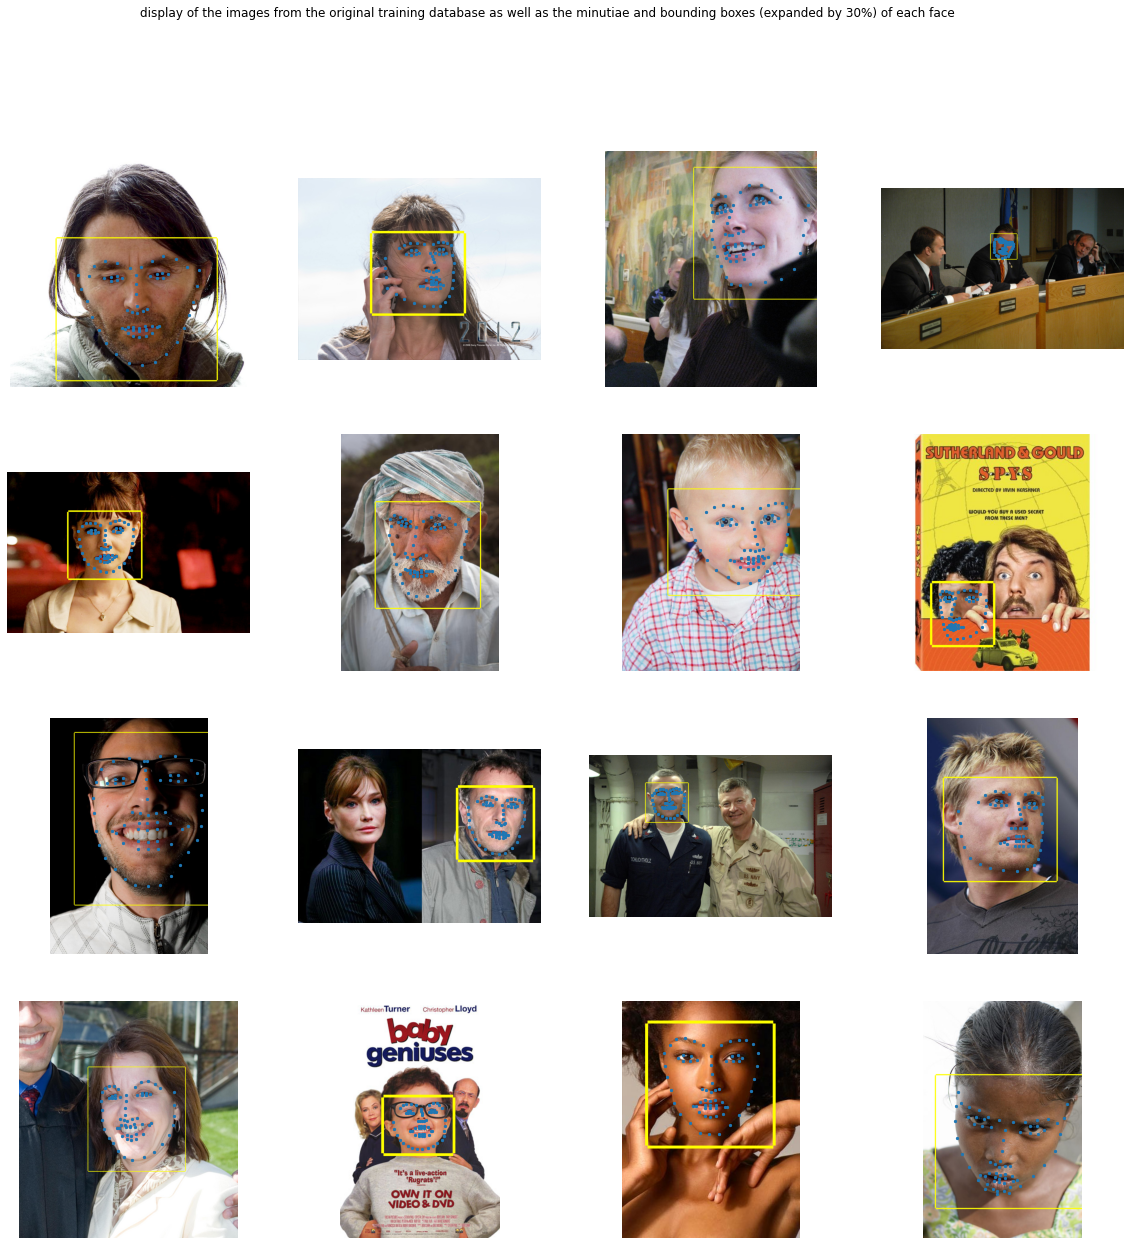

In [11]:
vew_images( images=train_images, 
            landmarks=train_landmarks, 
            nb_images=16,
            random_display=True, 
            grid=False, 
            total_cols=4, 
            s=5, 
            bounding_box=True, 
            color='yellow', 
            expansion_rate=0.3,
            title='display of the images from the original training database as well as the minutiae and bounding boxes (expanded by 30%) of each face', 
            figsize=(20, 20)    )

Dans cet exemple, nous affichons 16 images aléatoires du jeu de données d'entraînement. A chaque exécution de la cellule ci-dessous, nous affichons 16 nouvelles images avec les points de repère et les boîtes englobantes correspondantes. Cela nous permet d'avoir une meilleure idée de la diversité des images de notre base de données. Cependant, nous avons remarqué que certains points de repère se trouvent aux bords des images, ce qui nous empêche de délimiter ces points avec des boîtes plus grandes sur ces côtés

##### 1.3 Augmentation des données

Pour chaque image de l’ensemble d’apprentissage, nous devons :  
    1. Calculer les paramètres de la boite englobante des points caractéristiques du visage.    
    2. Elargir cette boîte englobante de 30%, découper l’image avec ces nouvelles dimensions, redimensionner l’image en `128 ∗ 128` et enregistrer l’image.    
    3. Calculer les coordonnées des points caractéristiques pour cette nouvelle image. La position des points constituera la vérité terrain (nous afficherons l’image et les points caractéristique pour vérifier que ce prétraitement est effectif).  
    4. Calculer la position moyenne des points caractéristique sur l’ensemble des images de la base d’apprentissage.  
    5. Générer 10 perturbations aléatoires de la position des points caractéristiques (en translation et en facteur d’échelle) et enregistrer chacune de ces réalisations. L’amplitude de ces déformations sera de ±20% pour le facteur d’échelle et ±20px pour les translations (indépendamment en x et y). Pourquoi applique-t-on ces transformations ? Proposer une méthode automatique pour déterminer l’amplitudes de ces déplacements ?    

A la fin de cette étape nous disposons des données d’apprentissage dont nous aurons besoin pour apprendre notre modèle. Nous appliquons les mêmes transformations aux images de test (sans les perturbations aléatoires) afin d’être dans les mêmes conditions pour l’évaluation.  

Les questions 1, 2, 3 et 5 sont regroupées dans une seule fonction appelée `create_usable_dataset`. Nous traiterons également la question 4 qui consiste simplement à calculer la matrice de points de repère moyens.Enfin, la question 5 sera traitée dans une fonction nommée `generation_of_disturbed_data`.  

In [53]:
# This function processes questions 1.3.1 to 1.3.4
def create_usable_dataset(path_images, 
                          path_landmarks, 
                          registration_root_path, 
                          name_folder, 
                          expansion_rate=0.3): 
  
  """
  1. Calculer les paramètres de la boite englobante des points caractéristiques du visage.
  2. Elargir cette boîte englobante de 30%, découper l’image avec ces nouvelles dimensions, 
     redimensionner l’image en `128 ∗ 128` et enregistrer l’image.
  3. Calculer les coordonnées des points caractéristiques pour cette nouvelle image. 
     La position des points constituera la vérité terrain (vous afficherez l’image et 
     les points caractéristique pour vérifier que ce prétraitement est effectif).  
  """

  registration_path = os.path.join(registration_root_path, name_folder) 
  try : 
    os.mkdir(os.path.join(registration_path))
  except FileExistsError as e:
    print(e), sys.exit()
  
  with open(path_images) as file_images, open(path_landmarks) as file_landmarks:
    path_all_images = file_images.readlines()
    path_all_landmarks = file_landmarks.readlines()
  
  for i, path_image, path_landmark in tqdm(zip(range(len(path_all_images)), path_all_images, path_all_landmarks)):
    
    img = Image.open(path_image.strip())
    ld_marks = np.loadtxt(path_landmark.strip(), dtype=float, encoding='bytes')

    id_no = time.strftime('%Y%m%d_%H%M%S', time.localtime()) + str(i) + \
            str(random.randint(10000 + i, 99999 - i )) 

    x_max, y_max, x_min, y_min = extract_coordinates_bounding_box(img, ld_marks, expansion_rate)
    img = img.crop((x_min, y_min, x_max, y_max)).resize((128, 128))    
    w2, h2  = img.size
    img.save(os.path.join(registration_path, "sample_{:05d}.png".format(i)))
    img.close()
    
    ld_marks[:, 0], ld_marks[:, 1] = ld_marks[:, 0] - x_min, ld_marks[:, 1] - y_min
    ld_marks[:, 0], ld_marks[:, 1] = ld_marks[:, 0] * w2/(x_max-x_min), ld_marks[:, 1] * h2/(y_max-y_min)
    np.savetxt(os.path.join(registration_path, "sample_{:05d}.pts".format(i)), ld_marks)

In [13]:
create_usable_dataset(path_images=r'.\300w_train_images.txt', 
                      path_landmarks=r'.\300w_train_landmarks.txt', 
                      registration_root_path='.', 
                      name_folder='new_dataset', 
                      expansion_rate=0.3)

3148it [01:53, 27.77it/s]


In [54]:
def extract_file_path_dataset(path_dataset, 
                              name_backup_folder):
  try : 
    os.mkdir(os.path.join(name_backup_folder))
  except FileExistsError as e:
    print(e), sys.exit()

  path_images, path_landmarks = [], []
  for file_name in os.listdir(path_dataset):
    if file_name.endswith(('.png', '.jpg', '.jpeg')):
      path_images.append(os.path.join(path_dataset, file_name))
    if file_name.endswith('.pts'):
      path_landmarks.append(os.path.join(path_dataset, file_name))

  with open(os.path.join(name_backup_folder, '300w_train_images.txt'), 'w') as fi, \
       open(os.path.join(name_backup_folder, '300w_train_landmarks.txt'), 'w') as fl:
    for pth_img, pth_ldmks in zip(path_images, path_landmarks):
      # write each item on a new line
      fi.write(f"{pth_img}\n")
      fl.write(f"{pth_ldmks}\n")
   

In [16]:
extract_file_path_dataset(path_dataset=r'new_dataset', 
                          name_backup_folder=r'paths_of_new_dataset')

In [10]:
new_train_images, new_train_landmarks = create_dataset(path_images=os.path.join(current_path, r'paths_of_new_dataset\300w_train_images.txt'), 
                                                       path_landmarks=os.path.join(current_path, r'paths_of_new_dataset\300w_train_landmarks.txt'))


3148it [00:33, 95.21it/s] 


In [11]:
len(new_train_images), new_train_landmarks.shape

(3148, (3148, 68, 2))

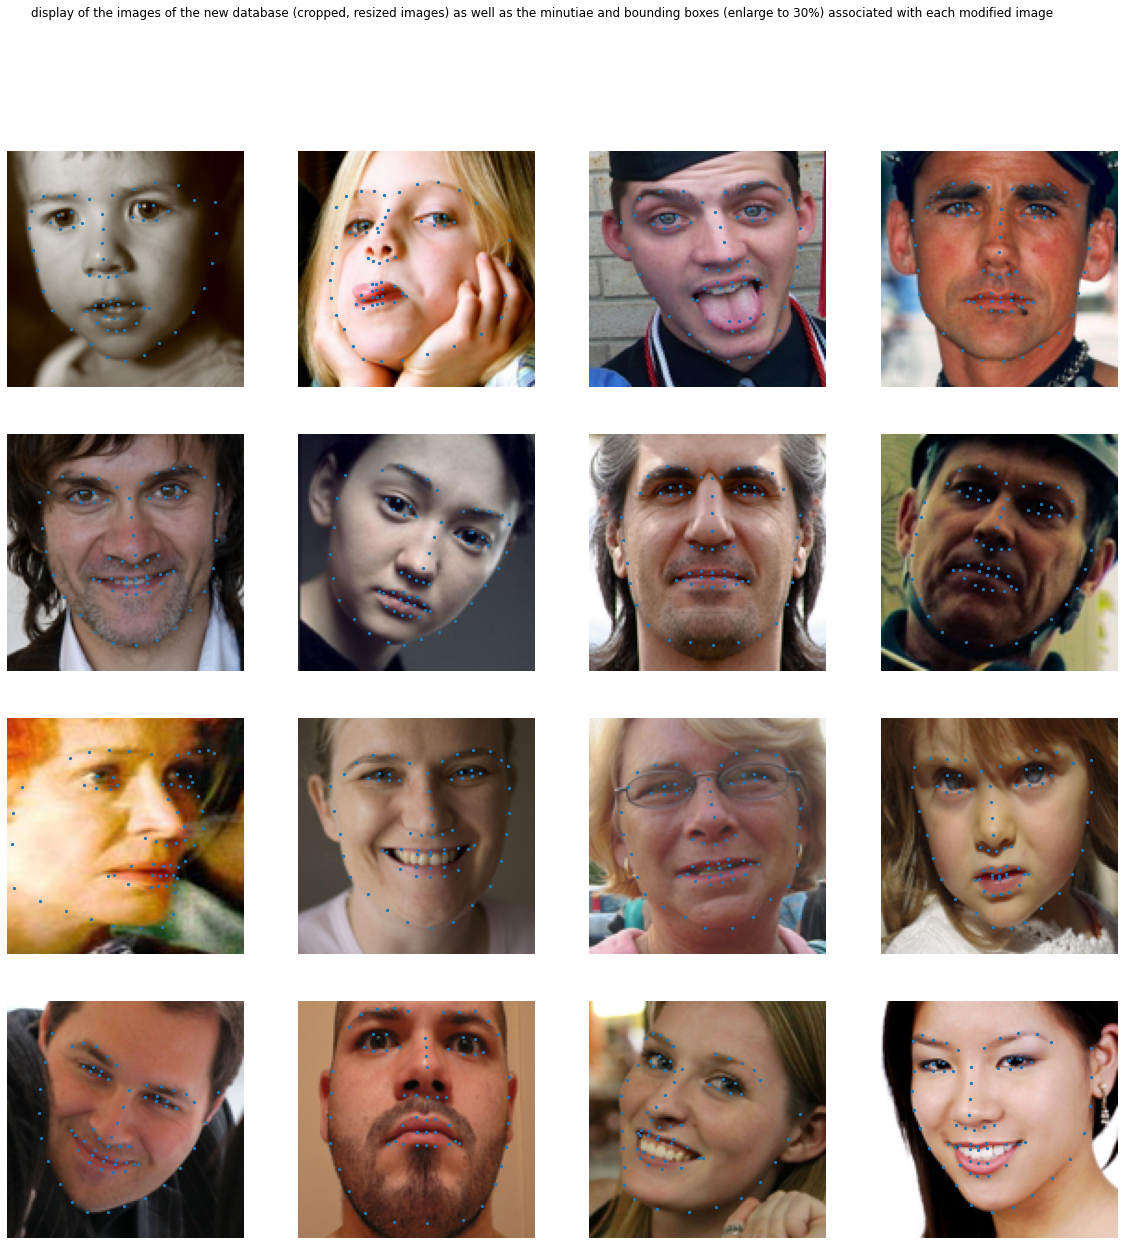

In [12]:
vew_images( images=new_train_images, 
            landmarks=new_train_landmarks, 
            nb_images=16,
            random_display=True, 
            grid=False, 
            total_cols=4, 
            s=5, 
            bounding_box=False, 
            color='yellow', 
            expansion_rate=0.3,
            title='display of the images of the new database (cropped, resized images) as well as the minutiae and bounding boxes (enlarge to 30%) associated with each modified image ',  
            figsize=(20, 20))

In [13]:
"""
1.3.4. Calculer la position moyenne des points caractéristique sur 
l’ensemble des images de la base d’apprentissage.
"""

average_characteristic_points = new_train_landmarks.mean(axis=1)

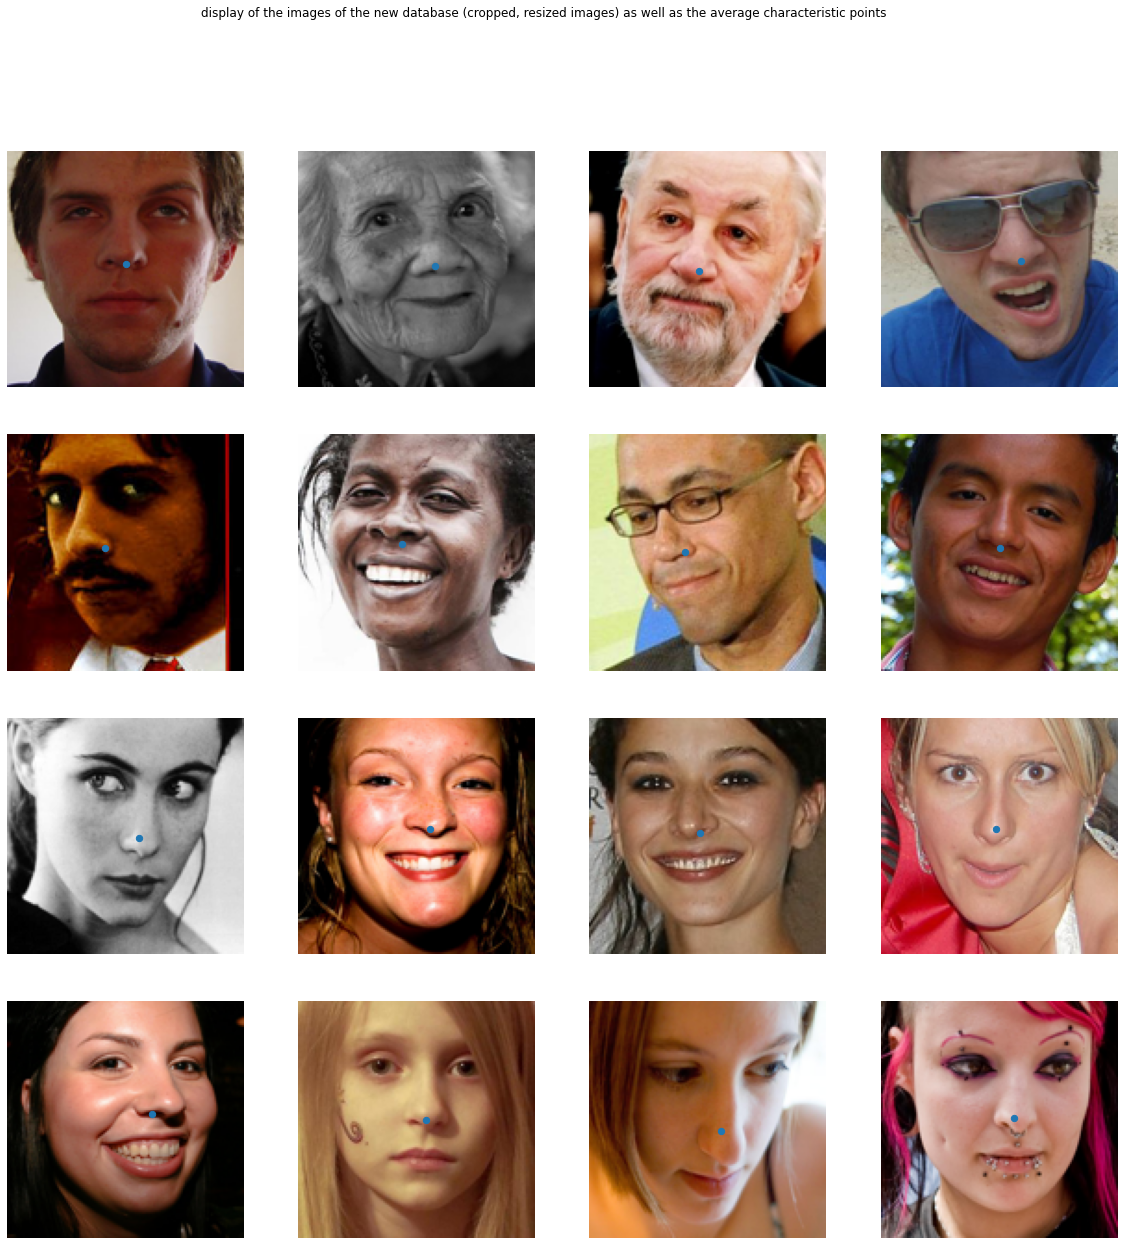

In [40]:
vew_images( images=new_train_images, 
            landmarks=average_characteristic_points, 
            nb_images=16,
            random_display=True, 
            grid=False, 
            total_cols=4, 
            s=40, 
            bounding_box=False, 
            color='yellow', 
            expansion_rate=0.3,
            title='display of the images of the new database (cropped, resized images) as well as the average characteristic points',  
            figsize=(20, 20))

Il est vrai que la majorité des points caractéristiques d'un visage se trouvent généralement au niveau du nez, en raison de sa position centrale sur le visage et de sa forme distinctive.  

Le nez est un élément important du visage en raison de sa forme et de sa position distinctives, qui sont facilement reconnaissables et permettent de différencier les visages les uns des autres. Le nez est également souvent considéré comme le centre du visage, car il se trouve généralement au milieu de celui-ci et est utilisé comme référence pour aligner les autres traits faciaux. En raison de son importance dans la reconnaissance faciale et dans l'analyse de l'expression, il n'est pas surprenant que la majorité des points caractéristiques se trouvent au niveau du nez.

In [55]:
# This function processes questions 1.3.5
def generation_of_disturbed_data( path_images, 
                                  path_landmarks, 
                                  full_path, 
                                  name_folder, 
                                  disruption_factor=(-20, 20), 
                                  expansion_rate=0.0, 
                                  nb_disturbances=10): 
  
  """
    5. Générer 10 perturbations aléatoires de la position des points caractéristiques (en translation et en facteur d’échelle)
       et enregistrer chacune de ces réalisations L’amplitude de ces déformations sera de ±20% pour le facteur d’échelle et 
       ±20px pour les translations (indépendamment en x et y). Pourquoi applique-t-on ces transformations ? Proposer une méthode 
       automatique pour déterminer l’amplitudes de ces déplacements ?
  """
  
  registration_path = os.path.join(full_path, name_folder) 
  try : 
    os.mkdir(os.path.join(registration_path))
  except FileExistsError as e:
    print(e), sys.exit()
  
  with open(path_images) as file_images, open(path_landmarks) as file_landmarks:
    path_all_images = file_images.readlines()
    path_all_landmarks = file_landmarks.readlines()
  
  min_disruption, max_disruption = disruption_factor 
  
  for i, path_image, path_landmark in tqdm(zip(range(len(path_all_images)), path_all_images, path_all_landmarks)):
    img_ = Image.open(path_image.strip())
    ld_ = np.loadtxt(path_landmark.strip(), dtype=float, encoding='bytes')
    x_max, y_max, x_min, y_min = extract_coordinates_bounding_box(img_, ld_, expansion_rate)
    w, h = img_.size

    for j in range(i*nb_disturbances, nb_disturbances*(i+1), 1):
      scale_rate = np.random.randint(min_disruption, max_disruption) / 100 
      translation_rate = (np.random.randint(min_disruption, max_disruption), 
                          np.random.randint(min_disruption, max_disruption))

      x_translation = ld_[:, 0] + translation_rate[0]
      y_translation = ld_[:, 1] + translation_rate[1]

      if  np.all(x_translation >= 0) and np.all(x_translation < w):
        ld_[:, 0] = x_translation
      if  np.all(y_translation >= 0) and np.all(y_translation < h):
        ld_[:, 1] =  y_translation
      
      scale_transforamtion = ld_ - (ld_ * scale_rate)

      if  np.all(scale_transforamtion[:, 0] >= 0)  and np.all(scale_transforamtion[:, 0] < w) and \
          np.all(scale_transforamtion[:, 1] >= 0)  and np.all(scale_transforamtion[:, 1] < h):
        ld_ = scale_transforamtion
      
      id_no = time.strftime('%Y%m%d_%H%M%S', time.localtime()) + str(j) + \
              str(random.randint(10000 + i, 99999 - i ))
      img_.save(os.path.join(registration_path, "sample_{:05d}.png".format(j)))
      np.savetxt(os.path.join(registration_path,"sample_{:05d}.pts".format(j)), ld_)
    img_.close()


  


In [14]:
generation_of_disturbed_data(   path_images=r'paths_of_new_dataset\300w_train_images.txt', 
                                path_landmarks=r'paths_of_new_dataset\300w_train_landmarks.txt', 
                                full_path='.', 
                                name_folder='data_disturbed', 
                                disruption_factor=(-20, 20), 
                                expansion_rate=0.0,
                                nb_disturbances=2  )

3148it [00:58, 53.76it/s]


In [17]:
extract_file_path_dataset(path_dataset=r'data_disturbed', name_backup_folder=r'paths_of_data_disturbed')

In [11]:
train_images_disturbed, train_landmarks_disturbed = create_dataset(path_images=r'paths_of_data_disturbed\300w_train_images.txt', 
                                                                  path_landmarks=r'paths_of_data_disturbed\300w_train_landmarks.txt')

In [13]:
vew_images( images=train_images_disturbed, 
            landmarks=train_landmarks_disturbed, 
            nb_images=16,
            random_display=False, 
            grid=False, 
            total_cols=4, 
            s=3, 
            bounding_box=True, 
            color='yellow', 
            expansion_rate=0.3,
            title="""
display the images of the new database (cropped, resized images) as well as the randomly perturbed minutiae \n
(in translation and in scale factor) associated to each modified image. The amplitude of these deformations are ±20% \n
for the scale factor and ±20px for the translations (independently in x and y).
""", 
            figsize=(20, 20))

NameError: name 'train_images_disturbed' is not defined

## 2. Apprentissage d’un régresseur simple

Dans cette partie, nous souhaitons estimer un **déplacement** des points caractéristiques à partir d’un modèle de points moyen, i.e. apprendre en utilisant des outils élémentaires de l’apprentissage statistique et de la vision par ordinateur, une fonction $$f : I, \s_{0} → \δ_{s}$$ telle que $$\s_{0} + \δ_{s} ≈ s^{∗}$$ au sens des moindres carrés.    

### 2.1 Extraction de caractéristiques image

Pour ce faire, une première étape consiste à $abstraire$ localement (i.e. au voisinage de chaque
point caractéristique) la représentation image.

1. Pourquoi ne peut-on pas utiliser directement les valeurs des pixels de l’image comme représentation?  

Il y a plusieurs raisons pour lesquelles on ne peut pas utiliser directement les valeurs des pixels de l'image comme représentation.

Tous d'abord, Les valeurs des pixels ne capturent pas toutes les informations d'une image. Elles ignorent la couleur et la texture de l'image, ainsi que d'autres caractéristiques qui pourraient être utiles pour cerner le contenu de l'image.  

Deuxièmement, les pixels d'une image sont généralement stockés en valeur numérique, ce qui signifie qu'ils ont une valeur numérique unique pour chaque canal de couleur (rouge, vert, bleu, etc.). Cependant, ces valeurs numériques ne sont pas directement interprétables par les modèles de machine learning, qui préfèrent généralement des vecteurs de nombres réels ou des matrices.  


Enfin, les pixels d'une image peuvent être très sensibles aux variations de lumière, de contraste et de perspective, ce qui peut rendre difficile l'apprentissage de modèles à partir de cette représentation. Par exemple, si nous souhaitons prédire des points caractéristiques d'un visage nous, utilisons une image de personne prise sous un angle différent comme entrée, il est peu probable que les pixels de cette image soient similaires à ceux de l'image originale. Cela peut rendre difficile la généralisation des modèles entraînés à partir de ces pixels.  

Pour pouvoir utiliser une image dans un modèle de machine learning, il est généralement nécessaire de transformer ses pixels en une représentation plus précise et plus facilement manipulable. Cela peut se faire en utilisant un descripteur, qui permet de capturer des caractéristiques clés de l'image et de les transformer en une représentation numérique. Cette représentation peut être sous forme de vecteur ou de matrice, et elle capture généralement plus d'informations que les pixels de l'image originale. En utilisant un descripteur, il devient donc possible de traiter une image de manière plus précise et plus adaptée à la tâche de vision par ordinateur à laquelle on s'intéresse.  Un bon discréteur doit être capable de capturer le contenu des images de manière précise et fiable. Il devrait également être robuste et pouvoir résister aux variations dans les conditions d'imagerie (rotation, translation, changements brusques de luminance, etc.) tout en conservant sa précision. Un bon discréteur devrait également être rapide à calculer et à intégrer à un programme, sans compromettre la qualité ou le temps de traitement.  

2. Créer, pour chaque point caractéristique courant du modèle moyen si 0i=0,...,68, un objet cv2.keyPoint en spécifiant ses coordonnées, et une taille de fenêtre (paramètre size, réglant le diamètre du voisinage) de 20 pixels.

3. Utiliser la fonction sift.compute de opencv pour calculer un descripteur SIFT au voisinage de chaque point caractéristique. Quel est la dimensionnalité de chacun de ces descripteurs?

Il existe de nombreux discréteurs qui peuvent être utilisés pour le traitement d'image. Nous alons utliser le discréteur `SIFT` (Scale-Invariant Feature Transform).  

Le descripteur SIFT est un algorithme de détection et de description de points caractéristiques utilisé dans le traitement d'images. Il est très populaire en raison de ses performances élevées dans l'extraction de caractéristiques spécifiques comme les couleurs, les textures et les contours.

Pour fonctionner, le SIFT utilise un bloc de 16x16 pixels autour d'un point d'intérêt et réoriente les gradients de sorte que l'orientation principale du bloc soit de 0° par exemple. Il divise ensuite le bloc en 4x4 sous-blocs et calcule l'histogramme des gradients (pondérés par leur norme) pour chaque sous-bloc. En utilisant un faible nombre de bins (généralement 8), le SIFT concatène les 16 histogrammes pour obtenir un vecteur de caractéristiques de 128 dimensions. Enfin, il normalise le vecteur de caractéristiques en utilisant une norme L2.

Chaque point caractéristique détecté par le SIFT est représenté par un vecteur de 128 dimensions composé de clés, d'orientations et de lignes équilibrées sur le plan de l'image. Ces informations sont utilisées pour comparer les points caractéristiques trouvés entre les images.

4. Pour chaque image, concaténer l’ensemble des descripteurs obtenus pour tous les points caractéristiques. Quelle est la dimension de ce descripteur?

La dimension du descripteur dépend du nombre de points caractéristiques détectés par le SIFT dans chaque image. Si chaque point caractéristique est représenté par un vecteur de 128 dimensions, alors la dimension du descripteur sera de 128 x le nombre de points caractéristiques dans l'image.

Dans notes cas, l'algorithme SIFT détecte 68 points caractéristiques dans une image, le descripteur de cette image aura une dimension de 8704 (128 x 68).  

Il est important de noter que la dimension du descripteur dépend non seulement du nombre de points caractéristiques dans l'image, mais aussi de la dimension de chaque vecteur de caractéristiques individuel. Si nous utilisons un descripteur de dimension différente (par exemple, 64 dimensions au lieu de 128), la dimension du descripteur final sera également différente.  

En concaténant l'ensemble des descripteurs SIFT pour chaque point caractéristique détecté dans chaque image, nous obtenons une matrice de descripteurs de dimension (3148, 8074). Cette matrice comprend 3148 lignes, chaque ligne correspondant à un descripteur SIFT pour un point caractéristique dans une image. Elle comprend également 8074 colonnes, chaque colonne correspondant à un descripteur SIFT de dimension 128 pour un point caractéristique dans une image donnée. En d'autres termes, la matrice finale est obtenue en concaténant l'ensemble des descripteurs SIFT pour chaque point caractéristique détecté dans chaque image de la base de données.    

5. Citer deux exemples de représentation image qui pourraient être utilisés à la place des descripteurs SIFT, en expliquant brièvement le principe sous-jacent.

Voici deux exemples de représentations d'images qui pourraient être utilisées à la place des descripteurs SIFT :  

Le descripteur BIN (Binary Robust Independent Elementary Features) : Ce descripteur d'image utilise une représentation binaire pour capturer les caractéristiques de l'image. Il est particulièrement robuste aux perturbations de l'image, comme les variations de luminosité ou de rotation, ce qui le rend utile pour la comparaison d'images.  

Le descripteur SURF (Speeded Up Robust Features) : Ce descripteur d'image utilise une représentation basée sur des ondelettes pour capturer les caractéristiques de l'image. Il est particulièrement rapide à calculer et robuste aux perturbations de l'image, ce qui le rend utile pour la comparaison d'images.  

Le descripteur BIN est un descripteur d'image binaire qui utilise une représentation binaire pour capturer les caractéristiques de l'image. Il est obtenu en utilisant une fonction de hash pour transformer chaque pixel de l'image en un vecteur binaire de longueur fixe. Le descripteur BIN est particulièrement robuste aux perturbations de l'image, ce qui le rend utile pour la comparaison d'images.  

Le descripteur SURF est un descripteur d'image qui utilise une représentation basée sur des ondelettes pour capturer les caractéristiques de l'image. Il est obtenu en transformant l'image en espace de contour, puis en utilisant une transformation en ondelette pour capturer les caractéristiques de l'image transformée. Le descripteur SURF est particulièrement rapide à calculer et robuste aux perturbations de l'image, ce qui le rend utile pour la comparaison d'images.

Dans cette section, nous avons des questions à la fois théoriques et pratiques/implémentation. Les questions théoriques sont traitées directement dans les cellules de questions, tandis que les questions d'implémentation sont développées dans des cellules de code dédiées.

Les questions 2, 3 et 4 ont été regroupées dans une fonction unique appelée `feature_extraction`, qui permet d'extraire les caractéristiques de l'image. Cette fonction prend en entrée les chemins vers les images et leurs points caractéristiques, ainsi que la taille du voisinage des points caractéristiques. Elle renvoie les descripteurs des points caractéristiques sous forme de vecteurs de caractéristiques.  

In [14]:
# def feature_extraction(path_images, path_landmarks, size):
#     """
#     2. Créer, pour chaque point caractéristique courant du modèle moyen si 0i=0,...,68, un objet cv2.keyPoint en 
#     spécifiant ses coordonnées, et une taille de fenêtre (paramètre size, réglant le diamètre du voisinage) de 20 pixels.

#     3. Utiliser la fonction sift.compute de opencv pour calculer un descripteur SIFT au voisinage de chaque point caractéristique. 
#     Quel est la dimensionnalité de chacun de ces descripteurs?

#     4. Pour chaque image, concaténer l’ensemble des descripteurs obtenus pour tous les points caractéristiques. 
#     Quelle est la dimension de ce descripteur?
#     """

#     with open(path_images) as file_images, open(path_landmarks) as file_landmarks:
#         path_all_images = file_images.readlines()
#         path_all_landmarks = file_landmarks.readlines()
    
#     descriptors, key_points = [],[]
#     sift = cv2.SIFT_create()
#     for i, path_image, path_landmarks in tqdm(zip(range(len(path_all_images)), path_all_images, path_all_landmarks)):
#         image = cv2.imread(path_image.strip(), 0)
#         landmarks = np.loadtxt(path_landmarks.strip(), dtype=float).mean(axis=0)

#         key_points.append(cv2.KeyPoint(x=landmarks[0], y=landmarks[1], size=size))
        
#     _, siftt = sift.compute(image, key_points)
#     descriptors.append(siftt)


#     # return np.array(descriptors).reshape(len(path_all_images), -1)
#     return np.array(descriptors)
        


In [15]:
# descriptors = feature_extraction(path_images=r'.\paths_of_new_dataset\300w_train_images.txt', 
#                                  path_landmarks=r'.\paths_of_new_dataset\300w_train_landmarks.txt', 
#                                  size=20)


3148it [00:05, 605.63it/s]


In [57]:
# descriptors.shape

(1, 3148, 128)

In [21]:
def feature_extraction(path_images, path_landmarks, size):
    """
    2. Créer, pour chaque point caractéristique courant du modèle moyen si 0i=0,...,68, un objet cv2.keyPoint en 
    spécifiant ses coordonnées, et une taille de fenêtre (paramètre size, réglant le diamètre du voisinage) de 20 pixels.

    3. Utiliser la fonction sift.compute de opencv pour calculer un descripteur SIFT au voisinage de chaque point caractéristique. 
    Quel est la dimensionnalité de chacun de ces descripteurs?

    4. Pour chaque image, concaténer l’ensemble des descripteurs obtenus pour tous les points caractéristiques. 
    Quelle est la dimension de ce descripteur?
    """

    with open(path_images) as file_images, open(path_landmarks) as file_landmarks:
        path_all_images = file_images.readlines()
        path_all_landmarks = file_landmarks.readlines()
    
    descriptors = []
    sift = cv2.SIFT_create()
    for i, path_image, path_landmarks in tqdm(zip(range(len(path_all_images)), path_all_images, path_all_landmarks)):
        image = cv2.imread(path_image.strip(), 0)
        landmarks = np.loadtxt(path_landmarks.strip(), dtype=float)

        key_points = [cv2.KeyPoint(x=ld[0], y=ld[1], size=size) for ld in landmarks]
        _, siftt = sift.compute(image, key_points)
        descriptors.append(siftt.flatten())
    
    # return np.array(descriptors).reshape(len(path_all_images), -1)
    return np.array(descriptors)
    
        


In [19]:
descriptors = feature_extraction(path_images=r'.\paths_of_new_dataset\300w_train_images.txt', 
                                 path_landmarks=r'.\paths_of_new_dataset\300w_train_landmarks.txt', 
                                 size=20)


3148it [00:53, 58.94it/s]


In [20]:
# 3148, 68, 128 --> 3148, 68*128, --> 3148, 8704
descriptors.shape

(3148, 8704)

##### 2.2 Réduction de dimensionalité

1. Quel est l’intérêt principal de la réduction de dimensionalité en machine learning? 
   Quelles sont les principales méthodes de réduction de dimensionalité?

La réduction de dimensionalité est une technique importante dans le domaine du traitement d'image et de la vision par ordinateur, car elle permet de réduire la complexité des données et d'améliorer les performances des algorithmes de machine learning en sélectionnant ou en transformant un sous-ensemble de caractéristiques pertinentes dans les données d'entrée. Cela permet également de réduire le temps de calcul et de simplifier les modèles en éliminant les caractéristiques redondantes ou peu pertinentes. La réduction de dimensionalité est particulièrement utile pour les descripteurs de points caractéristiques, qui peuvent avoir une dimensionnalité élevée et nécessiter une réduction afin d'améliorer les performances et la précision des algorithmes de machine learning.   

Il existe plusieurs méthodes de réduction de dimensionalité qui peuvent être utilisées dans ce contexte, telles que la projection linéaire, l'analyse en composantes principales (ACP) et la réduction de dimensionalité non-linéaire. Chacune de ces méthodes a ses propres avantages et inconvénients en termes de performance et de complexité, et le choix de la méthode la plus appropriée dépend de l'application spécifique et des données en jeu.  

2. Utiliser l’analyse en composante principale (ACP ou PCA en anglais - librairies opencv
ou skimage, au choix) en conservant 98% de la variance totale des descripteurs.

3. Quelles sont les dimensions de la matrice X˜ 0 obtenue par réduction de dimensionalité?

Au départ, nous avons un jeu de données composé d'images de visages et de leurs descripteurs, chaque image étant décrite par 8704 dimensions. En utilisant la technique de réduction de dimensionalité appelée Analyse en Composantes Principales (PCA) tout en conservant 98% de la variance, nous avons réduit la dimensionnalité de notre jeu de données à 3148x691, soit une réduction de 12 fois la dimension initiale. Cela a permis de réduire considérablement le temps de calcul et d'améliorer les performances du modèle.  

La question 2 est traitée dans les cellules de code suivantes. Cependant, nous avons utilisé la bibliothèque `sklearn` pour l'application de l'ACP.  

In [22]:
from sklearn.decomposition import PCA

In [25]:
X0 = descriptors

In [26]:
pca_model = PCA(n_components=0.98, svd_solver='full')

In [27]:
X0_ = pca_model.fit_transform(X0).T
A0 = pca_model.components_

In [28]:
X0_.shape, A0.shape

((691, 3148), (691, 8704))

##### 2.3 Estimation du déplacement


Maintenant que nous disposons de représentations images locales compressées pour chaque image de la base de donnée $X^*_0 = A_0 X_0$, nous souhaitons estimer une régression linéaire permettant de prédire un déplacement de l’ensemble des points caractéristiques $δ_s$ à partir de ces représentation. Formellement, ce déplacement vérifie.

1. Calculer la matrice $Y^˜_0$, la matrice de déplacements $δ^∗_s$.  

In [29]:
Y0 = np.concatenate((X0_, np.array([np.ones(X0_.shape[-1])])), axis=0)
Y0.shape

(692, 3148)

In [30]:
delta_opt = np.zeros((136, Y0.shape[1]))
ld_average = new_train_landmarks.mean(axis=0)
for i, ld_marks in enumerate(new_train_landmarks):
    ld_mean = ld_marks.mean(axis=0)
    delta_opt[:, i] = ld_marks.flatten() - ld_average.flatten()
delta_opt.shape

(136, 3148)

In [31]:
Y0.shape, delta_opt.shape

((692, 3148), (136, 3148))

2. Calculer R0 en appliquant une résolution aux moindres carrés et le déplacement R0Y˜0 pour chaque image (ou chaque ligne).  

In [33]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(Y0.T, delta_opt.T)

LinearRegression()

In [34]:
R0 = regressor.coef_
R0.shape

(136, 692)

3. Calculer l’erreur δ∗s − R0Y˜0 et afficher, pour la première image de la base, les points caractéristiques initiaux s0 (en vert) ainsi que les points déplacées s0 + δs. Que peut-on en conclure ?  

In [36]:
travel = R0@Y0
travel.shape

(136, 3148)

In [37]:
err = delta_opt - travel
err.shape

(136, 3148)

In [40]:
init_landmarks = new_train_landmarks.mean(axis=0)
travel_all_landmarks = init_landmarks + travel.T.reshape(3148, 68, 2)
init_landmarks.shape, travel_all_landmarks.shape

((68, 2), (3148, 68, 2))

In [45]:
nb_images = 8
s = 3

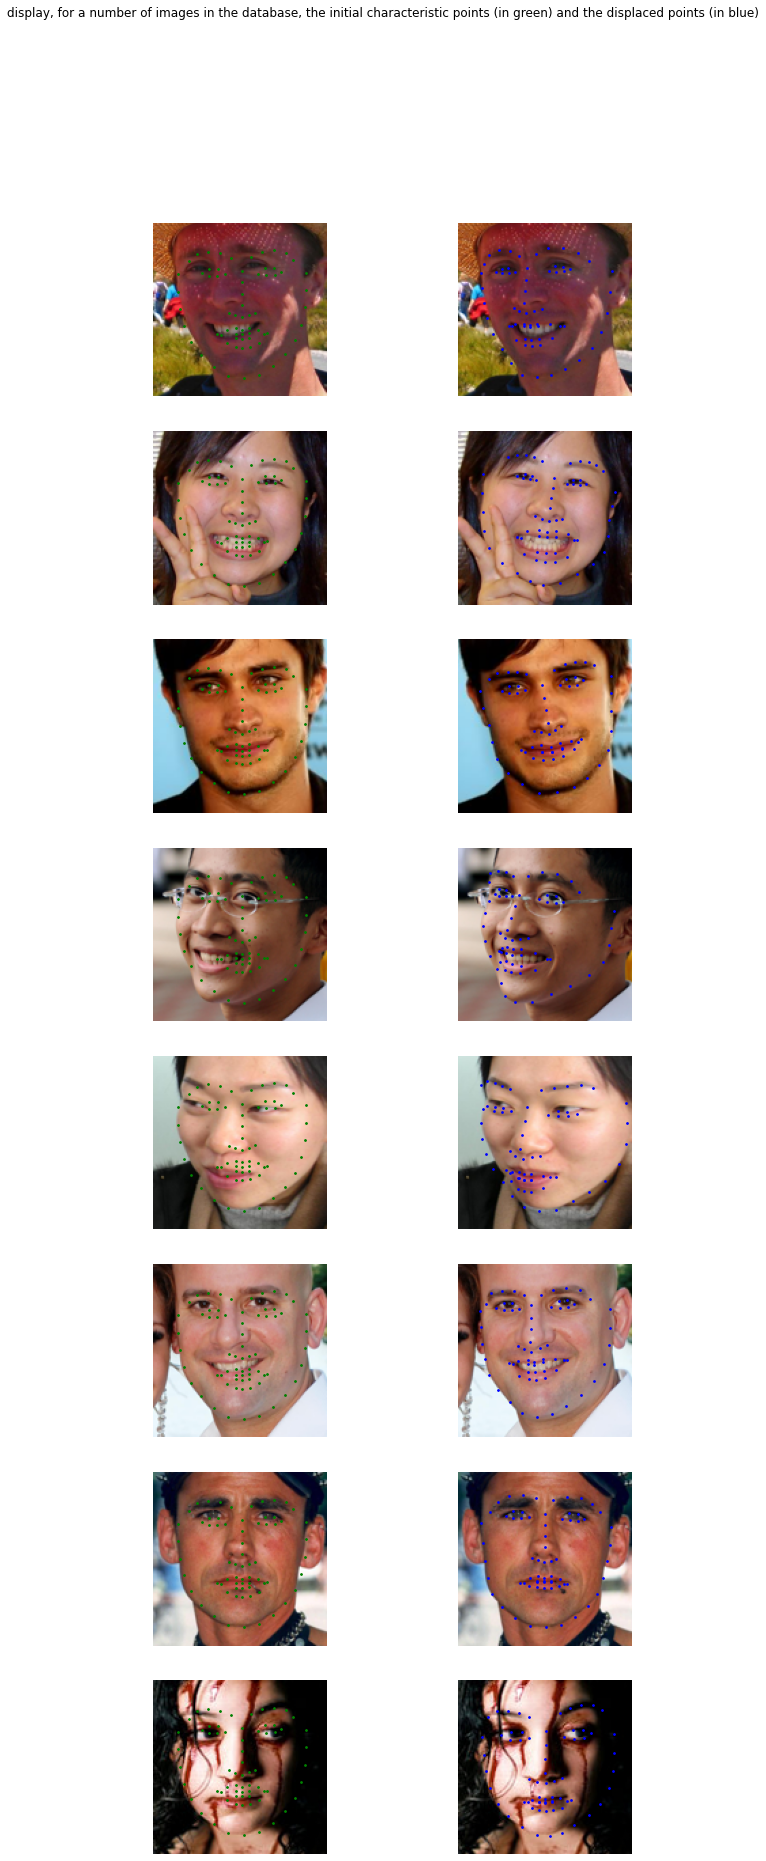

In [50]:

fig, axes = plt.subplots(nrows=nb_images, ncols=2, figsize=(10, 30))
axes = list(axes.flat)
random_indexes = np.array(random.sample(range(len(new_train_images)), nb_images)).repeat(repeats=2, axis=0)  

fig.suptitle('display, for a number of images in the database, the initial characteristic points (in green) and the displaced points (in blue)')
for i in range(1, nb_images*2, 2):
    axes[i-1].imshow(new_train_images[random_indexes[i]])
    axes[i-1].scatter(init_landmarks[:, 0], init_landmarks[:, 1], s=s, c='green')

    axes[i].imshow(new_train_images[random_indexes[i]])
    axes[i].scatter(travel_all_landmarks[random_indexes[i]][:, 0], travel_all_landmarks[random_indexes[i]][:, 1], s=s, c='blue')
    
    axes[i].set_axis_off(); axes[i-1].set_axis_off()

Comme nous pouvons le constater, le modèle arrive dans la majorité des cas à bien aligner les points caractéristiques des images de la base de données d'apprentissage, tous simplement nous exécutant la cellule suivante qui affiche des images aléatoires avec leurs points caractéristique initial qui est le modèle moyen ainsi les points corrigés. Cela n'est pas un signe d'une bonne performance de notre modèle, mais nous savons à paressent que ce dernier arrive à apprendre l'alignement des points caractéristique.   Pour évaluer la robustesse de notre modèle nous devons par la suite le confronté à des images qui n'as jamais vu. Pour ce faire, nous avons à disposition une base de données de test que nous devons utiliser.  

### 2.4 Validation sur un ensemble de test externe

A partir d’une position de départ s<sub>0</sub>, les matrices A<sub>0</sub> et R<sub>0</sub> apprises respectivement par ACP et régression aux moindres carrés définissent le modèle d’alignement de points caractéristiques. Etant donné une nouvelle image, l’alignement est effectué en extrayant les descripteurs SIFTs autour de chaque point (en s<sub>0</sub>), en compressant cette représentation (multiplication matricielle par A<sub>0</sub>), en ajoutant le terme de biais permettant d’obtenir Ỹ<sub>0</sub>, puis en appliquant une multipli- cation matricielle par R<sub>0</sub>. Il conviendra donc d’enregistrer les valeurs contenues dans s<sub>0</sub> (forme moyenne), A<sub>0</sub> (matrice de projection de l’ACP), et R<sub>0</sub> (coefficients des régressions linéaires).


1. En quoi l’évaluation précédente n’est-elle pas pertinente pour évaluer la capacité de généralisation de la procédure d’alignement de points caractéristiques ?  

Précédemment nous avons évaluer notre modèle en utilisant la base de données d'apprentissage, cette procédure nous ne permet pas de mesurer sa capacité de généralisation, c'est-à-dire sa capacité à bien fonctionner sur des données qu'il n'a pas vues pendant l'entraînement. En effet, l'évaluation d'un modèle est généralement basée sur les performances du modèle sur les données d'entraînement ou sur un ensemble de données de validation, qui ont été utilisées pour ajuster les paramètres du modèle. Si le modèle a été entraîné et ajusté de manière optimale sur ces données, il peut très bien avoir de bonnes performances sur ces données sans pour autant être capable de généraliser ses résultats à de nouvelles données. Pour évaluer la capacité de généralisation d'un modèle, il est donc nécessaire de l'évaluer sur un ensemble de données indépendant, qui n'a pas été utilisé pendant l'entraînement ou la validation du modèle.    

2. Calculer l’erreur δ∗ s −R0Y˜ 0 sur le set de test et afficher, pour la première image de la base, les points caractéristiques initiaux s0 (en vert) ainsi que les points déplacées s0 + δs. Que peut-on en conclure?  

Dans cette étape, nous prétraiterons également la base de données de test en suivant la même procédure que celle utilisée pour la base de données d'apprentissage. Cela implique le recadrage et le redimensionnement des images de test de la même manière.  

In [57]:
create_usable_dataset(path_images=r'.\lfpw_testset.txt', 
                      path_landmarks=r'.\lfpw_testset_landmarks.txt', 
                      registration_root_path='.', 
                      name_folder='new_lfpw_testset', 
                      expansion_rate=0.3)

224it [00:07, 30.89it/s]


In [58]:
extract_file_path_dataset(path_dataset=r'new_lfpw_testset', 
                          name_backup_folder=r'paths_of_new_lfpw_testset')

In [59]:
new_test_images, new_test_landmarks = create_dataset(path_images=os.path.join(current_path, r'paths_of_new_lfpw_testset\300w_train_images.txt'), 
                                                       path_landmarks=os.path.join(current_path, r'paths_of_new_lfpw_testset\300w_train_landmarks.txt'))


224it [00:02, 87.28it/s]


In [64]:
len(new_test_images), new_test_landmarks.shape

(224, (224, 68, 2))

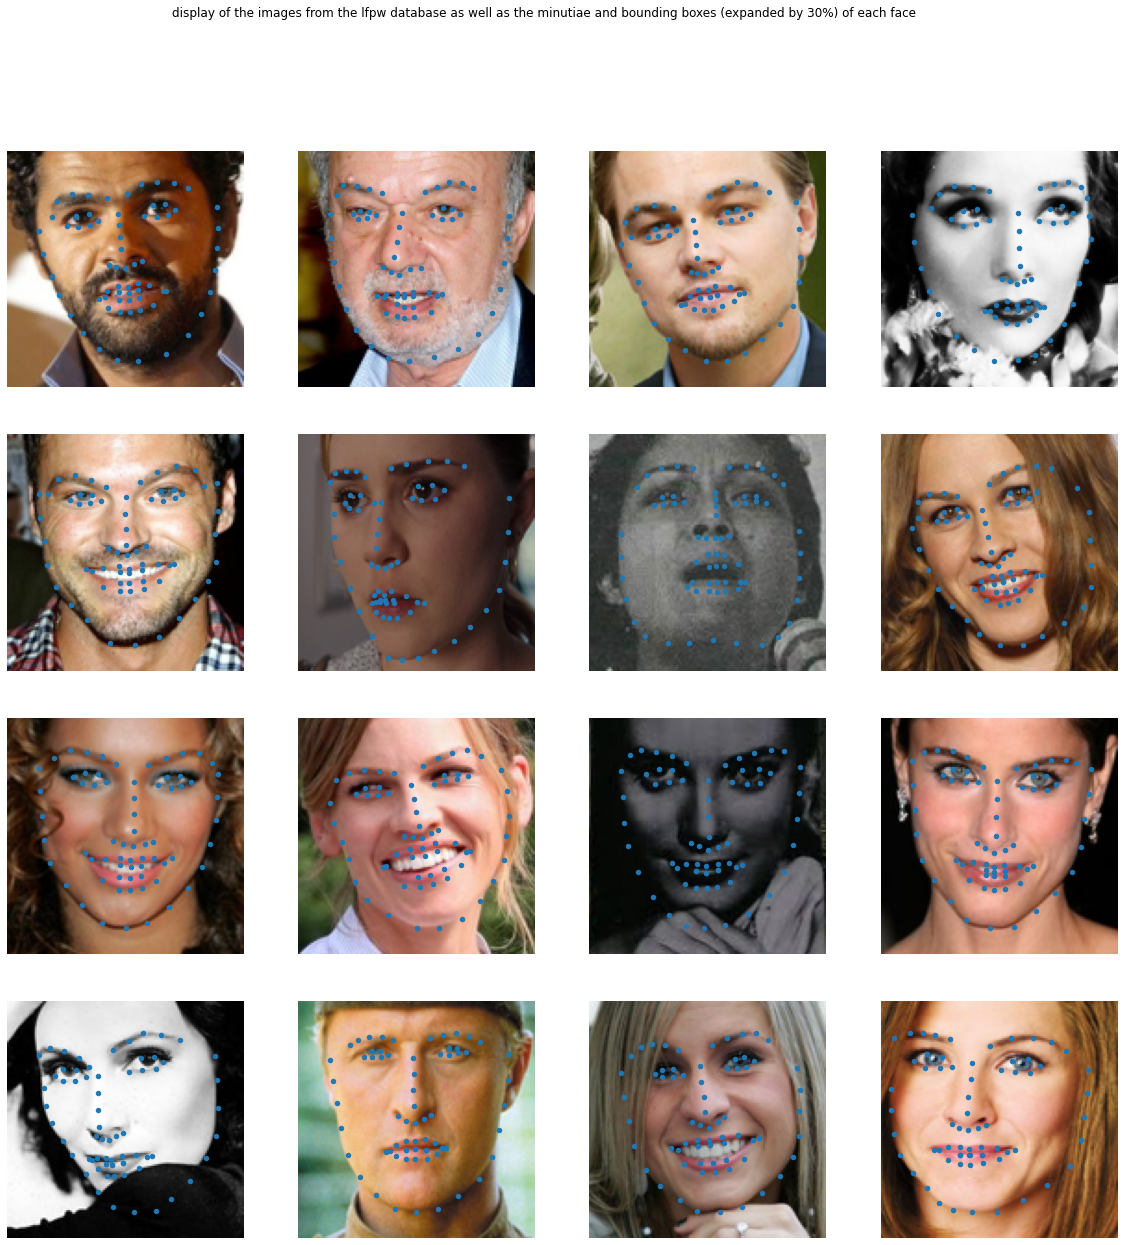

In [62]:
vew_images( images=new_test_images, 
            landmarks=new_test_landmarks, 
            nb_images=16,
            random_display=True, 
            grid=False, 
            total_cols=4, 
            s=20, 
            bounding_box=False, 
            color='yellow', 
            expansion_rate=0.3,
            title='display of the images from the lfpw database as well as the minutiae and bounding boxes (expanded by 30%) of each face', 
            figsize=(20, 20)    )

In [75]:
X0_test = feature_extraction(path_images=r'.\paths_of_new_lfpw_testset\300w_train_images.txt', 
                             path_landmarks=r'.\paths_of_new_lfpw_testset\300w_train_landmarks.txt', 
                             size=20)
X0_test.shape

224it [00:04, 54.25it/s]


(224, 8704)

In [76]:
A0.shape

(691, 8704)

In [78]:
X0_test_ = (X0_test @ A0.T).T
X0_test_.shape

(691, 224)

In [79]:
Y0_test = np.concatenate((X0_test_, np.array([np.ones(X0_test_.shape[-1])])), axis=0)
Y0_test.shape

(692, 224)

In [80]:
delta_opt_test = np.zeros((136, Y0_test.shape[1]))
ld_average = new_train_landmarks.mean(axis=0)
for i, ld_marks in enumerate(new_train_landmarks):
    ld_mean = ld_marks.mean(axis=0)
    delta_opt[:, i] = ld_marks.flatten() - ld_average.flatten()
delta_opt_test.shape

(136, 224)

In [81]:
travel_test = R0 @ Y0_test
travel_test.shape

(136, 224)

In [83]:
err = delta_opt_test - travel_test
err.shape

(136, 224)

In [ ]:
init_landmarks = new_train_landmarks.mean(axis=0)
travel_all_landmarks = init_landmarks + travel_test.T.reshape(3148, 68, 2)
init_landmarks.shape, travel_all_landmarks.shape

In [84]:
np_images = 8
s = 3

Dans ce cas, la performance de notre modèle est évaluée en utilisant une base de données de test, qui contient des images et leurs points caractéristiques qui n'ont pas été utilisés pour l'entraînement du modèle. Nous pouvons utiliser cette base de données pour évaluer la capacité du modèle à aligner correctement les points caractéristiques sur des images qu'il n'a pas vues auparavant. Ainsi, en comparant les points caractéristiques initialement présents sur ces images avec ceux corrigés par notre modèle, nous pourrons déterminer la précision de notre modèle dans l'alignement des points caractéristiques. Cela nous permettra de mieux comprendre la qualité de notre modèle et de déterminer s'il est capable de généraliser ses apprentissages à de nouvelles données.

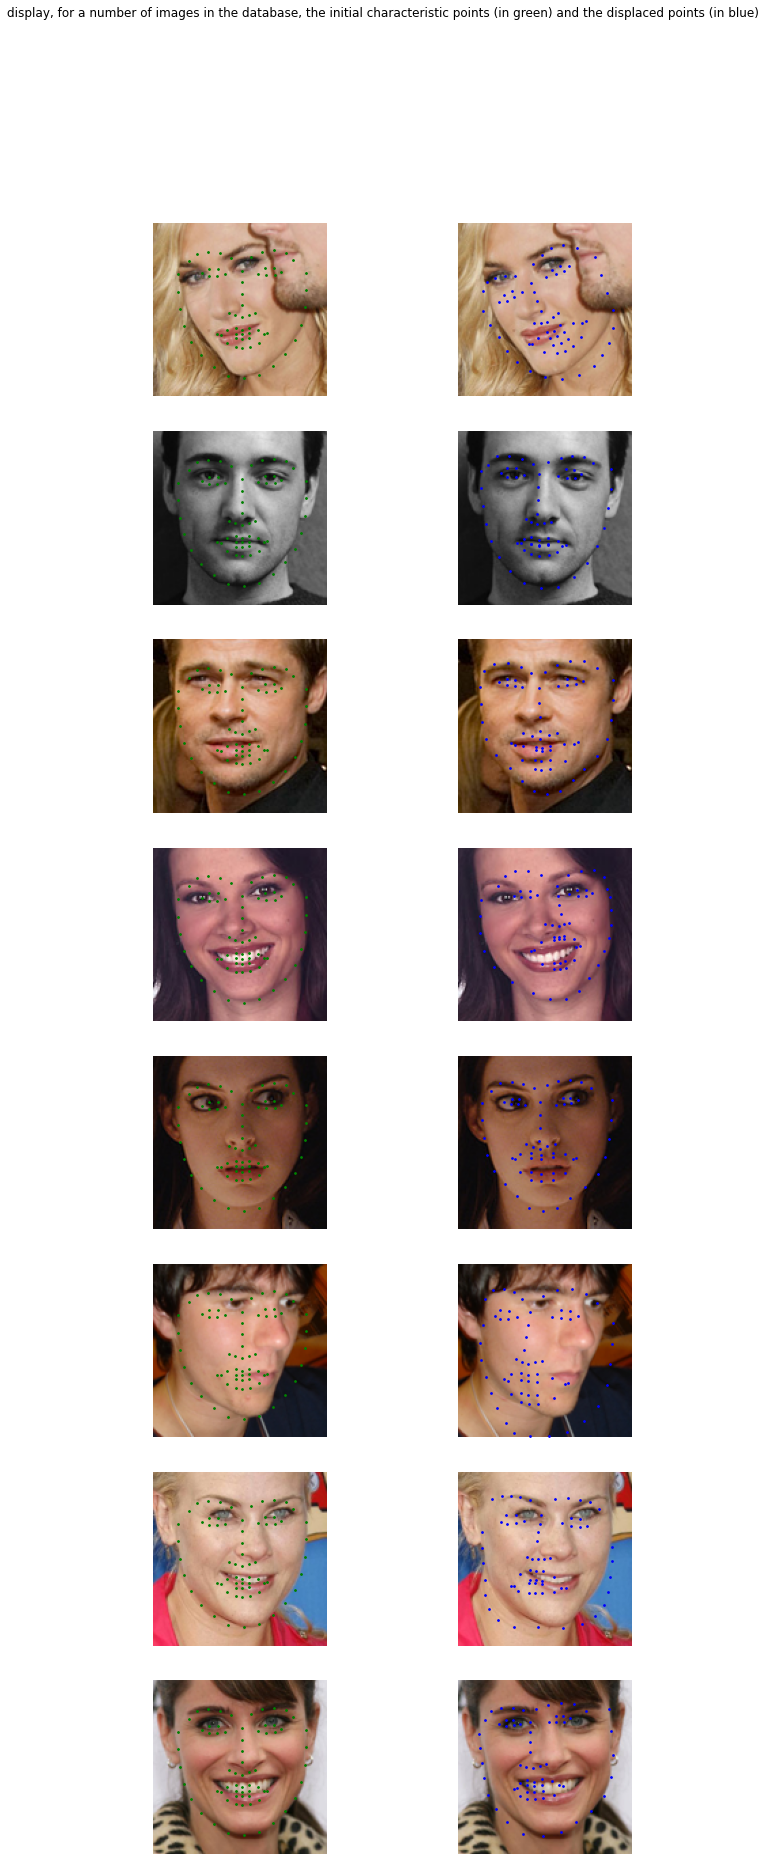

In [85]:

fig, axes = plt.subplots(nrows=nb_images, ncols=2, figsize=(10, 30))
axes = list(axes.flat)
random_indexes = np.array(random.sample(range(len(new_test_images)), nb_images)).repeat(repeats=2, axis=0)  

fig.suptitle('display, for a number of images in the database, the initial characteristic points (in green) and the displaced points (in blue)')
for i in range(1, nb_images*2, 2):
    axes[i-1].imshow(new_test_images[random_indexes[i]])
    axes[i-1].scatter(init_landmarks[:, 0], init_landmarks[:, 1], s=s, c='green')

    axes[i].imshow(new_test_images[random_indexes[i]])
    axes[i].scatter(travel_all_landmarks[random_indexes[i]][:, 0], travel_all_landmarks[random_indexes[i]][:, 1], s=s, c='blue')
    
    axes[i].set_axis_off(); axes[i-1].set_axis_off()

Le modèle de machine learning utilisé semble avoir été efficace dans l'apprentissage des caractéristiques des images de la base de données d'entraînement, ce qui se reflète dans sa capacité à aligner de manière satisfaisante les points caractéristiques sur des images qu'il n'a jamais vues auparavant, en utilisant comme référence le modèle moyen. Toutefois, il existe encore une certaine erreur dans l'alignement de ces points sur certaines images, ce qui montre qu'il y a encore des améliorations possibles pour réduire cette erreur.  